In [23]:
# Cell 1: imports and global parameters

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Physical / numerical parameters (baseline)
L = 1.0          # domain length
N = 200          # number of spatial intervals -> N+1 grid points
dx = L / N

c_const = 1.0    # constant wave speed (for baseline)
lambda_cfl = 0.9 # Courant factor < 1 for stability
dt = lambda_cfl * dx / c_const

tmax = 2.0       # final time

# Initial Gaussian parameters
x0 = 0.3 * L
sigma = 0.05

# Boundary condition type: "dirichlet", "neumann", "periodic"
bc_type = "dirichlet"

# Flags / parameters for later exercises
use_variable_c = False      # Exercise 3
use_5pt_laplacian = False   # Exercise 4
eps_damp = 0.0              # Exercise 5 (numerical damping strength)
use_nonz_initial_ut = False # Exercise 2
A_ut = 0.0                  # amplitude for u_t(x,0)


In [24]:
# Cell 2: grid and helper functions

x = np.linspace(0.0, L, N + 1)

def apply_boundary(u, bc_type="dirichlet"):
    """
    Enforce boundary conditions in-place on array u.
    bc_type: "dirichlet", "neumann", or "periodic".
    """
    if bc_type == "dirichlet":
        # u(0,t) = u(L,t) = 0
        u[0] = 0.0
        u[-1] = 0.0

    elif bc_type == "neumann":
        # TODO (Exercise 1.2):
        # Implement Neumann BC: u_x(0,t)=0, u_x(L,t)=0
        # Simple approximation: u[0] = u[1], u[-1] = u[-2]
        u[0] = 0.0  # placeholder: replace with correct formula
        u[-1] = 0.0

    elif bc_type == "periodic":
        # TODO (Exercise 1.3):
        # Implement periodic BC: u[0] = u[-2], u[-1] = u[1], etc.
        # A simple version:
        u[0] = 0.0   # placeholder
        u[-1] = 0.0  # placeholder

    else:
        raise ValueError("Unknown bc_type: {}".format(bc_type))


def laplacian_3pt(u, dx):
    """
    Standard 3-point Laplacian for interior points.
    Returns an array of same shape as u.
    """
    lap = np.zeros_like(u)
    lap[1:-1] = (u[2:] - 2.0 * u[1:-1] + u[:-2]) / dx**2
    return lap


def laplacian_5pt(u, dx):
    """
    5-point Laplacian (Exercise 4).
    For simplicity, use 5-point stencil on j=2..N-2
    and fall back to 3-point near boundaries.
    """
    lap = np.zeros_like(u)
    # Near boundaries: fallback to 3-point
    lap[1:-1] = (u[2:] - 2.0 * u[1:-1] + u[:-2]) / dx**2

    # TODO (Exercise 4):
    # Replace interior j=2..N-2 entries by 5-point formula:
    # (-u[j+2] + 16u[j+1] - 30u[j] + 16u[j-1] - u[j-2]) / (12 dx^2)
    # for j in range(2, N-1):  # up to N-2 index
    #     ...
    return lap


def dissipation_KO(u, eps):
    """
    Kreiss-Oliger-like dissipation (Exercise 5).
    Returns an array D_j = u[j+2] - 4u[j+1] + 6u[j] - 4u[j-1] + u[j-2].
    We set D_j = 0 near boundaries where stencil does not fit.
    """
    D = np.zeros_like(u)
    if eps == 0.0:
        return D

    # TODO (Exercise 5):
    # Implement the 5-point KO-like operator on j=2..N-2, zero elsewhere.
    return D


In [25]:
# Cell 3: initial conditions

def initial_conditions(x, x0, sigma, use_nonz_ut=False, A=0.0, L=1.0):
    """
    Returns u0(x) and ut0(x) at t=0.
    - u0 is Gaussian.
    - ut0 is either zero or A * sin(2π x / L) depending on use_nonz_ut.
    """
    # Displacement
    u0 = np.exp(-0.5 * ((x - x0) / sigma)**2)

    # Time derivative
    if use_nonz_ut:
        # TODO (Exercise 2):
        # Implement ut0(x) = A * sin(2π x / L)
        ut0 = np.zeros_like(x)  # placeholder
    else:
        ut0 = np.zeros_like(x)

    return u0, ut0


# Build c(x) for Exercise 3 (piecewise constant), but default is constant
def build_cx_array(x, c_const, use_variable_c=False, c1=1.0, c2=2.0, L=1.0):
    """
    Returns array c_x[j] = c(x_j).
    If use_variable_c is False, returns constant c_const.
    If True, use piecewise c1 (left half) and c2 (right half).
    """
    c_x = np.zeros_like(x) + c_const
    if use_variable_c:
        mid = 0.5 * L
        c_x[x < mid] = c1
        c_x[x >= mid] = c2
    return c_x


In [26]:
# Cell 4: set up state arrays and first time step

# Build c(x)
c_x = build_cx_array(x, c_const, use_variable_c=use_variable_c,
                     c1=1.0, c2=2.0, L=L)

# For CFL with variable c, one could use max(c_x):
c_max = np.max(c_x)
dt = lambda_cfl * dx / c_max
lambda2_base = (dt / dx)**2  # will multiply by c_x^2 later

print(f"dx = {dx:.4e}, dt = {dt:.4e}, CFL based on max(c) = {c_max*dt/dx:.3f}")

# Initial conditions
u_prev, ut0 = initial_conditions(
    x, x0, sigma,
    use_nonz_ut=use_nonz_initial_ut,
    A=A_ut, L=L
)

apply_boundary(u_prev, bc_type=bc_type)

# Compute u_curr = u^1 using Taylor expansion
lap0 = laplacian_3pt(u_prev, dx)  # baseline Laplacian
u_curr = np.copy(u_prev)

# If ut0 != 0, include the linear term in Δt
u_curr[1:-1] = (
    u_prev[1:-1]
    + dt * ut0[1:-1]  # will be zero if ut0=0
    + 0.5 * (c_x[1:-1]**2) * lambda2_base * (u_prev[2:] - 2*u_prev[1:-1] + u_prev[:-2])
)

apply_boundary(u_curr, bc_type=bc_type)

t = dt  # time corresponding to u_curr


dx = 5.0000e-03, dt = 4.5000e-03, CFL based on max(c) = 0.900


In [27]:
# Cell 5: one time step function

def step(u_prev, u_curr, dx, dt, c_x, bc_type="dirichlet",
         use_5pt=False, eps_damp=0.0):
    """
    Advance solution by one time step using 3-level scheme:
    u_next = 2 u_curr - u_prev + (c(x)^2 dt^2) * u_xx(u_curr).
    Optionally uses 5-point Laplacian and KO dissipation.
    """
    u_next = np.zeros_like(u_curr)

    if use_5pt:
        lap = laplacian_5pt(u_curr, dx)
    else:
        lap = laplacian_3pt(u_curr, dx)

    # c(x)^2 factor
    # lambda2_base = (dt/dx)^2 has been precomputed,
    # but we can also do ((c_x*dt)/dx)**2 directly:
    lambda2_j = (c_x * dt / dx)**2

    u_next[1:-1] = (
        2.0 * u_curr[1:-1]
        - u_prev[1:-1]
        + lambda2_j[1:-1] * (u_curr[2:] - 2.0*u_curr[1:-1] + u_curr[:-2])
    )

    # Apply KO dissipation if eps_damp > 0
    if eps_damp != 0.0:
        D = dissipation_KO(u_curr, eps_damp)
        u_next[1:-1] -= eps_damp * D[1:-1]

    apply_boundary(u_next, bc_type=bc_type)

    return u_next


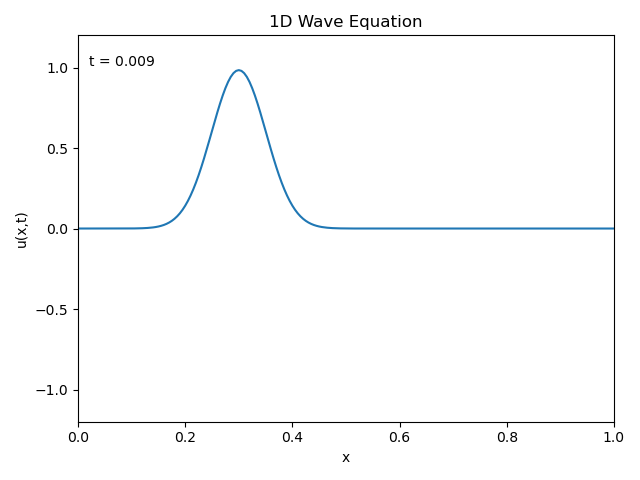

In [28]:
# Cell 6: set up Matplotlib figure and animation
%matplotlib widget
fig, ax = plt.subplots()
line, = ax.plot(x, u_curr)
ax.set_xlim(0.0, L)
ax.set_ylim(-1.2, 1.2)
ax.set_xlabel("x")
ax.set_ylabel("u(x,t)")
ax.set_title("1D Wave Equation")

time_text = ax.text(0.02, 0.95, f"t = {t:.3f}",
                    transform=ax.transAxes, ha="left", va="top")

plt.tight_layout()

def init_anim():
    line.set_ydata(u_curr)
    time_text.set_text(f"t = {t:.3f}")
    return line, time_text

def update_anim(frame):
    global u_prev, u_curr, t
    u_next = step(u_prev, u_curr, dx, dt, c_x,
                  bc_type=bc_type,
                  use_5pt=use_5pt_laplacian,
                  eps_damp=eps_damp)
    u_prev, u_curr = u_curr, u_next
    t += dt
    line.set_ydata(u_curr)
    time_text.set_text(f"t = {t:.3f}")
    return line, time_text

nframes = int(tmax / dt)

ani = FuncAnimation(
    fig, update_anim, init_func=init_anim,
    frames=nframes, interval=30, blit=True
)

plt.show()
